In [1]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import scipy.io as sio
from scipy import signal
import numpy.linalg

In [181]:
ExpPath = '/srv/home/chenyu/DEbackup/032019/ACQ2/'
ExpName = 'ACQ2'
rx = 100;
ry = 100;
PACBED = np.zeros((512,512))
for irow in range(ry):
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
        PACBED = PACBED + Sample

PACBED = PACBED / rx / ry
np.save(ExpPath + 'Averaged_diffraction.npy',PACBED)

[[397 319]
 [376 164]
 [327 294]
 [305 139]
 [255 270]
 [233 115]
 [183 244]
 [133 375]
 [112 220]]


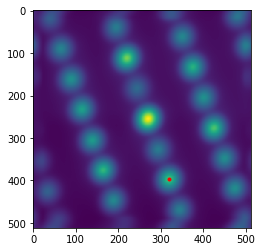

In [187]:
PACBED_conv = FrameConv(PACBED,mask_fft)
image_max = ndi.maximum_filter(PACBED_conv, size=30, mode='constant')
coordinates = peak_local_max(PACBED_conv, min_distance=20)
coordinates = coordinates[(coordinates[:,0]>100) & (coordinates[:,0]<400)]   # Filter away points too close to edge
coordinates = coordinates[(coordinates[:,1]>100) & (coordinates[:,1]<400)]
plt.imshow(PACBED_conv)
plt.plot(coordinates[0,1], coordinates[0,0], 'r.')
print(coordinates)

In [189]:
# Find all peak positions
mask = np.heaviside(PACBED[220:300,220:300]-30,1)   # generate mask from zero beam
mask_fft = np.fft.fft2(np.pad(mask, (216,216), 'constant', constant_values=(0, 0)))
x_loc = np.zeros((rx,ry,10))   # create matrix to hold all 4 x/y locations
y_loc = np.zeros((rx,ry,10))
for irow in range(ry):
    if irow % 10 ==0:
        print("Now working on row " + str(irow))
    for icol in range(rx):
        nSample = irow * rx + icol + 1
        Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
        Sample_conv = FrameConv(Sample, mask_fft)
        (loc_x,loc_y) = DiskLocate(Sample_conv)
        if loc_x.shape[0]==10:
            x_loc[irow,icol,:] = np.asarray([x for _,x in sorted(zip(loc_y,loc_x))])
            y_loc[irow,icol,:] = np.sort(loc_y)
        else:
            x_loc[irow,icol,:] = x_loc[irow,icol-1,:]
            y_loc[irow,icol,:] = y_loc[irow,icol-1,:]

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90


In [190]:
np.save(ExpPath + 'Peaks_x.npy',x_loc)
np.save(ExpPath + 'Peaks_y.npy',y_loc)

In [166]:
# Find target peaks for each frame
# standard positions of three points in [x,y], first one is undiffracted beam
ref = np.array([[268,245],[318,396],[163,375]])
# matrix to save exact positions of positions for the whole scan
# indexed in order of beam_x, beam_y, peak_index
x_pos = np.zeros((100,100,3))
y_pos = np.zeros((100,100,3))

for irow in range(ry):
    if irow % 10 ==0:
        print("Now working on row " + str(irow))
    for icol in range(rx):
        for i in range(3):
            dist = np.array([x_loc[irow,icol,:]-ref[i,0],y_loc[irow,icol,:]-ref[i,1]])
            dist = np.sqrt(np.square(dist[0,:])+np.square(dist[1,:]))
            if np.amin(dist) < 10:
                x_pos[irow,icol,i] = x_loc[irow,icol,np.argmin(dist)] # x position
                y_pos[irow,icol,i] = y_loc[irow,icol,np.argmin(dist)] # y position
            # if no peak position is detected within 15 px of reference, use the position of previous beam position
            elif icol != 0:
                x_pos[irow,icol,i] = x_pos[irow,icol-1,i]
            else:
                y_pos[irow,icol,i] = y_pos[irow-1,99,i]

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90


In [171]:
from scipy.linalg import polar
# Create reference with top right corner
g1_ref = np.mean(np.mean(x_loc[-40:,-40:,0] - x_loc[-40:,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[-40:,-40:,0] - y_loc[-40:,-40:,1],axis=0),axis=0)

g2_ref = np.mean(np.mean(x_loc[-40:,-40:,2] - x_loc[-40:,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[-40:,-40:,2] - y_loc[-40:,-40:,1],axis=0),axis=0)

Eaa = np.zeros((100,100))
Ebb = np.zeros((100,100))
Eab = np.zeros((100,100))
Erot = np.zeros((100,100))

for irow in range(ry):
    if irow % 10 ==0:
        print("Now working on row " + str(irow))
    for icol in range(rx):
        g1 = x_loc[irow,icol,0] - x_loc[irow,icol,1], y_loc[irow,icol,0] - y_loc[irow,icol,1]
        g2 = x_loc[irow,icol,2] - x_loc[irow,icol,1], y_loc[irow,icol,2] - y_loc[irow,icol,1]
        F = linalg.solve([g1_ref,g2_ref],[g1,g2])
        R,U = polar(F) # polar decomposition F=RU, R is the first output as default
        Eaa[irow,icol] = 1 - U[0,0]
        Ebb[irow,icol] = 1 - U[1,1]
        Eab[irow,icol] = U[0,1]
        Erot[irow,icol] = np.arcsin(R[0,1])   # asin in radian

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90


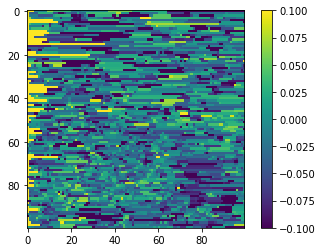

In [172]:
plt.imshow(Eaa,clim=[-0.1,0.1])
plt.colorbar()

In [173]:
irow = 60
icol = 70
ref_1 = np.array([268,245])
dist = np.array([x_loc[irow,icol,:]-ref_1[0],y_loc[irow,icol,:]-ref_1[1]])
dist = np.sqrt(np.square(dist[0,:])+np.square(dist[1,:]))
print(dist)
print(amin(dist))
print(np.argmin(dist))

[144.36374201 154.00547165  63.09285418 131.45106097 152.97870557
   5.13197182 151.60216873  91.15051581 169.26674213 155.95147826]
5.13197181514237
5


[154.41773276 296.99646528 135.50382054 275.49265211 113.38201339
 247.82160847 379.15146135 218.91086321] [375.58650975 337.29910328 310.32147437 261.27779382 226.77072699
 185.70335107 133.7881052  118.22636639]


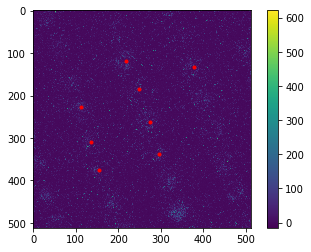

In [194]:
irow = 20
icol = 0
nSample = irow * rx + icol + 1
Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
Sample_conv = FrameConv(Sample,mask_fft)
(loc_x,loc_y) = DiskLocate(Sample_conv)
plt.imshow(Sample)
plt.colorbar()
plt.plot(loc_x, loc_y, 'r.')
print(loc_x, loc_y)

In [99]:
def DiskLocate(im):
    image_max = ndi.maximum_filter(im, size=100, mode='constant')
    coordinates = peak_local_max(im, min_distance=30)
    coordinates = coordinates[(coordinates[:,0]>100) & (coordinates[:,0]<400)]   # Filter away points too close to edge
    coordinates = coordinates[(coordinates[:,1]>100) & (coordinates[:,1]<400)]
#     peaks_x_fit = coordinates[:,1]
#     peaks_y_fit = coordinates[:,0]
    peaks_x_fit = []
    peaks_y_fit = []
    for i in range(coordinates.shape[0]):

        x = int(coordinates[i][1])
        y = int(coordinates[i][0])

        patch = im[y-30:y+30,x-30:x+30]
        bg = np.amin(patch)
        guess = (bg,patch[30,30]-bg,30, 30, 30, 30)
        bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,60,60,np.inf,np.inf])
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-30)
        peaks_y_fit.append(param[3]+y-30)
        
    return (np.asarray(peaks_x_fit), np.asarray(peaks_y_fit))

In [29]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

def fitGaussianx2(patch, guess, bounds):
    x = np.linspace(0, patch.shape[1]-1, patch.shape[1])
    y = np.linspace(0, patch.shape[0]-1, patch.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, patch.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt


In [7]:
def FrameConv(Sample, mask_fft):
    Sample_fft = np.fft.fft2(Sample)
    Sample_conv = np.fft.fftshift(np.fft.ifft2(Sample_fft * mask_fft))
    Sample_conv = Sample_conv.real
    return(Sample_conv)